<a href="https://colab.research.google.com/github/rroxy08/CE888/blob/master/assignment2/assign2_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#######################      home-credit-default-risk   #########################
######################  dataset-2 column-122 ############################
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random as rd
import os
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB 
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from scipy.stats import entropy
from sklearn.decomposition import PCA
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier

#drive.mount('/content/gdrive')
os.environ['KAGGLE_USERNAME'] = "khaledabegum"
os.environ['KAGGLE_KEY'] = "3ab75f2bb1de78f9addea9a3f5079ec9"


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
!kaggle competitions download --force -c home-credit-default-risk


  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 76.4MB/s]
 77% 84.0M/109M [00:00<00:00, 68.7MB/s]
100% 109M/109M [00:00<00:00, 118MB/s]  
 89% 86.0M/96.7M [00:00<00:00, 79.2MB/s]
100% 96.7M/96.7M [00:00<00:00, 105MB/s] 
 97% 74.0M/76.3M [00:00<00:00, 51.8MB/s]
100% 76.3M/76.3M [00:01<00:00, 78.5MB/s]
 99% 268M/271M [00:02<00:00, 161MB/s]
100% 271M/271M [00:02<00:00, 137MB/s]
 86% 5.00M/5.81M [00:00<00:00, 52.0MB/s]
100% 5.81M/5.81M [00:00<00:00, 53.4MB/s]
 91% 33.0M/36.1M [00:00<00:00, 34.5MB/s]
100% 36.1M/36.1M [00:00<00:00, 67.0MB/s]
 57% 21.0M/36.8M [00:00<00:00, 49.8MB/s]
100% 36.8M/36.8M [00:00<00:00, 123MB/s] 
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 39.6MB/s]
 83% 47.0M/56.8M [00:00<00:00, 57.6MB/s]
100% 56.8M/56.8M [00:00<00:00, 83.3MB/s]


In [3]:
!pip install densratio
from densratio import densratio

In [4]:
from zipfile import ZipFile

file_names = ["/content/application_train.csv.zip","/content/application_test.csv.zip"]

for file_name in file_names:
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('done')

done
done


In [0]:
def read_data():
  root_path1 = '/content/application_train.csv' 
  root_path2 = '/content/application_test.csv' 
  df_train=pd.read_csv(root_path1)
  df_test=pd.read_csv(root_path2)
  print(df_train.shape)
  print(df_test.shape)
  return df_train, df_test

In [0]:
#preprocessing of data, fillup the NAN value. Since 'year' data types are float so mode is used to fill NAN samples.
def process_data(df_train, df_test):
  df_tr=df_train.sample(120000)
  df_ts=df_test.copy()
  df_tr.count
  df_tr.shape
  for i in df_tr.columns:
      if (df_tr[i].dtype == 'object'or df_tr[i].dtype == 'float'):
        df_tr[i] = df_tr[i].fillna(df_tr[i].mode().iloc[0])
      if (df_tr[i].dtype == 'int'):
        df_tr[i] = df_tr[i].fillna(np.mean(df_tr[i]))

  for i in df_ts.columns:
      if (df_ts[i].dtype == 'object' or df_ts[i].dtype == 'float'):
        df_ts[i] = df_ts[i].fillna(df_ts[i].mode().iloc[0])
      if (df_ts[i].dtype == 'int'):
        df_ts[i] = df_ts[i].fillna(np.mean(df_ts[i]))

  ## Label encoding for string/categorical values
  number = LabelEncoder()
  for i in df_tr.columns:
      if (df_tr[i].dtype == 'object'):
        df_tr[i] = number.fit_transform(df_tr[i].astype('str'))
        df_tr[i] = df_tr[i].astype('object')

  for i in df_ts.columns:
      if (df_ts[i].dtype == 'object'):
        df_ts[i] = number.fit_transform(df_ts[i].astype('str'))
        df_ts[i] = df_ts[i].astype('object')
  return df_tr, df_ts

In [0]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [0]:
def data_histogram(df_tr,df_ts):
  training=df_tr.copy()
  testing=df_ts.copy()

  bin_val=10
  x = np.linspace( 0, 10, 45000)
  column_shift=dict()

  for i in range(len(training.columns)):
    col=training.columns[i]
    if(col !='TARGET'):
      hist_1, bins1 = np.histogram(training[col], bins=bin_val) 
      hist_2, bins2 = np.histogram(testing[col], bins=bin_val)
    
      hist_int=return_intersection(hist_1, hist_2)
      if(hist_int<0.9 and hist_int>0.0):
        column_shift[col]=hist_int
        
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(121) 
        ax1.hist(training[col], bins=bin_val, color='blue',label='train data',alpha=0.2) 
        ax1.hist(testing[col], bins=bin_val, color='red',label='test data', alpha=0.2)
        ax1.plot(bins1[0:bin_val],hist_1,'--') 
        ax1.plot(bins2[0:bin_val],hist_2,'--')
        ax1.set_title('column- '+col+' - '+ str(hist_int)) 
        ax1.legend()
        
  return column_shift



In [0]:
def data_validation(df_tr,df_ts):

  #merge two dataset

  if('TARGET' in df_tr.columns):
    del df_tr['TARGET']

  df_tr['is_test'] = range(1, len(df_tr) + 1)
  df_ts['is_test'] = range(1, len(df_ts) + 1)

  df_tr['is_test'] = 0
  df_ts['is_test'] = 1

  df_merge=pd.concat([df_tr, df_ts], sort = False)

  if('SK_ID_CURR' in df_merge.columns):
    del df_merge['SK_ID_CURR']
  
  Y=df_merge['is_test']

  if('is_test' in df_merge.columns):
    del df_merge['is_test']

  X_train, X_test, y_train, y_test = train_test_split(df_merge,Y, test_size=0.2)
  return X_train, X_test, y_train, y_test

In [0]:
def naive_bayes_classifier(Xtr,ytr,Xts,yts,density):
  clf = GaussianNB()
  if(density=='none'):
    clf.fit(Xtr,ytr) 
  else:
    clf.fit(Xtr,ytr,sample_weight=density) 
  #clf.fit(Xtr, ytr)
  y_pred=clf.predict(Xts)
  acc_scr=accuracy_score(yts, y_pred)
  #print("ROC-AUC: ",accuracy_score(yts, y_pred))
  scores=clf.score(Xts,yts)
  cross_scores=cross_val_score(clf,Xts,yts,cv=10)

  return cross_scores,acc_scr,scores

In [0]:
from keras.regularizers import l1
def neural_classifier_model():
  
  #X_train=np.array(X_train)
  dim= feature_num
  #unit=int(dim/2)
  
  classifier = Sequential()
  #First Hidden Layer
  classifier.add(Dense(units=120, activation='relu', input_dim=dim, kernel_initializer='random_normal',activity_regularizer=l1(0.01))) #
  #Second  Hidden Laye
  classifier.add(Dense(units=60,activation='relu', kernel_initializer='random_normal',activity_regularizer=l1(0.01)))
   #Third  Hidden Layer
  classifier.add(Dense(units=32,activation='relu', kernel_initializer='random_normal', activity_regularizer=l1(0.01)))
  #Dropout
  #classifier.add(Dropout(0.5))
  #Output Layer
  classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

  #Compiling the neural network
  classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])   #sparse_categorical_crossentropy''
  return classifier


In [0]:
def neural_classifier(X_train, y_train,X_test,y_test,density):
  #len(np.array(X_train))
  #classifier=neural_classifier_model()
  classifier = KerasClassifier(build_fn=neural_classifier_model)

  if(density=='none'):
    clf_fit=classifier.fit(X_train, y_train,validation_data=[X_test,y_test],epochs=2)
  else:
    clf_fit=classifier.fit(X_train, y_train, validation_data=[X_test,y_test],sample_weight=density,epochs=2)
  
 
  
  y_pred=classifier.predict(X_test)
  y_pred=(y_pred>0.5)
  acc=accuracy_score(y_test, y_pred)
  scores=np.mean(clf_fit.history['accuracy'])

  cross_scores=cross_val_score(classifier,X_test,y_test,cv=10)

  return cross_scores,acc,scores

In [0]:
def data_density_ratio(Xtr,Xts):
  arr_train=np.array(Xtr)
  arr_test=np.array(Xts)

  # Estimate the density ratio w
  dratio =densratio(arr_train,arr_test, kernel_num=5)
  density_ratio = dratio.compute_density_ratio(arr_train)
  return density_ratio

In [0]:
def data_PCA(Xtr,Xts,comp_num):

  pca = PCA(n_components=comp_num)
  fit= pca.fit(Xtr)
  
  trainX_pca = pca.transform(Xtr)
  testX_pca  = pca.transform(Xts)

  return np.array(trainX_pca), np.array(testX_pca)

(307511, 122)
(48744, 121)


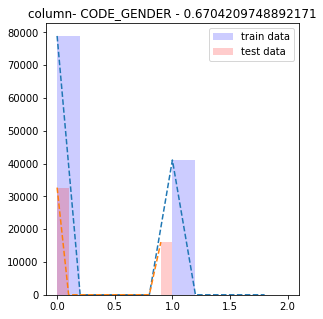

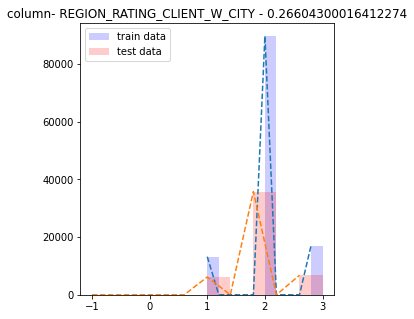

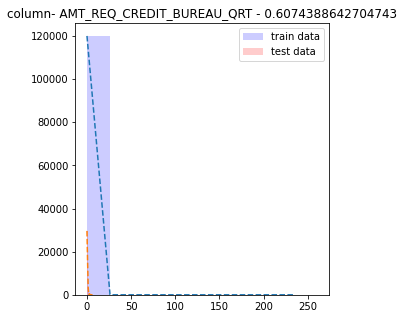

In [15]:
#Main function call.........
df_train, df_test =read_data()
df_train, df_test=process_data(df_train, df_test)
column_shift=[]
column_Shift_dens=[]
##################################covariate shift detection through histogram visualization, and histogram intersection#################
column_shift=data_histogram(df_train,df_test)
################################################# generate train and velidation dataset###############################
Xtr,Xts,ytr,yts = data_validation(df_train,df_test)

In [31]:
#classifiers' performance with covariate shift data
feature_num=len(Xtr.columns)
cross_nb,accuracy_nb,score_nb=naive_bayes_classifier(Xtr,ytr,Xts,yts,'none')
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb)
print("Learning Score of Naive Bayes classifier: ",score_nb)
cross_nc,accuracy_nc,score_nc=neural_classifier(Xtr,ytr,Xts,yts,'none')
print("Learning accuracy of Neural Network classifier: ",accuracy_nc)
print("Learning accuracy of Neural Network classifier: ",score_nc)
print("Learning accuracy of Neural Network classifier: ",cross_nc)

Learning accuracy of Naive Bayes classifier:  0.46030993510918844
Learning Score of Naive Bayes classifier:  0.46030993510918844
Train on 134995 samples, validate on 33749 samples
Epoch 1/2
134995/134995 [==============================] - 14s 107us/step - loss: 3452.9840 - accuracy: 0.7064 - val_loss: 1.5045 - val_accuracy: 0.7151
Epoch 2/2
134995/134995 [==============================] - 14s 102us/step - loss: 1.1158 - accuracy: 0.7102 - val_loss: 0.6046 - val_accuracy: 0.7151
Epoch 1/1
3375/3375 [==============================] - 0s 36us/step
Epoch 1/1
3375/3375 [==============================] - 0s 34us/step
Epoch 1/1
3375/3375 [==============================] - 0s 34us/step
Epoch 1/1
3375/3375 [==============================] - 0s 36us/step
Epoch 1/1
3375/3375 [==============================] - 0s 34us/step
Epoch 1/1
3375/3375 [==============================] - 0s 35us/step
Epoch 1/1
3375/3375 [==============================] - 0s 35us/step
Epoch 1/1
3375/3375 [====================

In [0]:
#print("Number of columns with covariate shift ",len(column_shift))
#print("Columns with covariate shift: ",column_shift)
Xtr_drop=Xtr.copy()
Xts_drop=Xts.copy()
for col in column_shift:
  if(column_shift[col]<0.8):
    if(col in Xtr_drop.columns):
      del Xtr_drop[col]
      del Xts_drop[col]

In [33]:
#classifiers' performance with covariate shift data, DROPPING features ############################
feature_num=len(Xtr_drop.columns)
print(Xtr.shape)
print(Xtr_drop.shape)
cross_nb_drop,accuracy_nb,score_nb=naive_bayes_classifier(Xtr_drop,ytr,Xts_drop,yts,'none')
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb)
print("Learning Score of Naive Bayes classifier: ",score_nb)
cross_nc_drop,accuracy_nc,score_nc=neural_classifier(Xtr_drop,ytr,Xts_drop,yts,'none')
print("Learning accuracy of Neural Network classifier: ",accuracy_nc)
print("Learning accuracy of Neural Network classifier: ",score_nc)

(134995, 120)
(134995, 117)
Learning accuracy of Naive Bayes classifier:  0.46125811135144745
Learning Score of Naive Bayes classifier:  0.46125811135144745
Train on 134995 samples, validate on 33749 samples
Epoch 1/2
134995/134995 [==============================] - 17s 125us/step - loss: 2834.4247 - accuracy: 0.7070 - val_loss: 1.4557 - val_accuracy: 0.7151
Epoch 2/2
134995/134995 [==============================] - 16s 120us/step - loss: 25.7388 - accuracy: 0.7102 - val_loss: 0.5999 - val_accuracy: 0.7151
Epoch 1/1
3375/3375 [==============================] - 0s 35us/step
Epoch 1/1
3375/3375 [==============================] - 0s 36us/step
Epoch 1/1
3375/3375 [==============================] - 0s 34us/step
Epoch 1/1
3375/3375 [==============================] - 0s 35us/step
Epoch 1/1
3375/3375 [==============================] - 0s 36us/step
Epoch 1/1
3375/3375 [==============================] - 0s 37us/step
Epoch 1/1
3375/3375 [==============================] - 0s 35us/step
Epoch 1/1
33

In [24]:
density=data_density_ratio(Xtr,Xts)
  

RuLSIF starting...
Searching for the optimal sigma and lambda...
sigma = 0.00100, lambda = 0.00100, score = 0.00000
sigma = 0.00100, lambda = 0.01000, score = 0.00000
sigma = 0.00100, lambda = 0.10000, score = 0.00000
sigma = 0.00100, lambda = 1.00000, score = 0.00000
sigma = 0.00100, lambda = 10.00000, score = 0.00000
sigma = 0.00100, lambda = 100.00000, score = 0.00000
sigma = 0.00100, lambda = 1000.00000, score = 0.00000
sigma = 0.00100, lambda = 10000.00000, score = 0.00000
sigma = 0.00100, lambda = 100000.00000, score = 0.00000
sigma = 0.00100, lambda = 1000000.00000, score = 0.00000
sigma = 0.00100, lambda = 10000000.00000, score = 0.00000
sigma = 0.00100, lambda = 100000000.00000, score = 0.00000
sigma = 0.00100, lambda = 1000000000.00000, score = 0.00000
sigma = 0.01000, lambda = 0.00100, score = 0.00000
sigma = 0.01000, lambda = 0.01000, score = 0.00000
sigma = 0.01000, lambda = 0.10000, score = 0.00000
sigma = 0.01000, lambda = 1.00000, score = 0.00000
sigma = 0.01000, lambda

In [35]:
feature_num=len(Xtr.columns)

cross_nb_dens,accuracy_nb_dens,score_nb_dens=naive_bayes_classifier(Xtr,ytr,Xts,yts,density)
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb_dens)
print("Learning score of Naive Bayes classifier: ",score_nb_dens)
cross_nc_dens,accuracy_nc_dens,score_nc_dens=neural_classifier(Xtr,ytr,Xts,yts,density)
print("Learning accuracy of Neural Network classifier: ",accuracy_nc_dens)
print("Learning score of Neural Network classifier: ",score_nc_dens)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Learning accuracy of Naive Bayes classifier:  0.5809949924442206
Learning score of Naive Bayes classifier:  0.5809949924442206


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Train on 134995 samples, validate on 33749 samples
Epoch 1/2
134995/134995 [==============================] - 16s 122us/step - loss: 2998.4612 - accuracy: 0.7064 - val_loss: 0.8754 - val_accuracy: 0.7150
Epoch 2/2
134995/134995 [==============================] - 16s 120us/step - loss: 0.8499 - accuracy: 0.7102 - val_loss: 0.5977 - val_accuracy: 0.7151
Epoch 1/1
3375/3375 [==============================] - 0s 36us/step
Epoch 1/1
3375/3375 [==============================] - 0s 34us/step
Epoch 1/1
3375/3375 [==============================] - 0s 37us/step
Epoch 1/1
3375/3375 [==============================] - 0s 36us/step
Epoch 1/1
3375/3375 [==============================] - 0s 37us/step
Epoch 1/1
3375/3375 [==============================] - 0s 37us/step
Epoch 1/1
3375/3375 [==============================] - 0s 36us/step
Epoch 1/1
3375/3375 [==============================] - 0s 35us/step
Epoch 1/1
3375/3375 [==============================] - 0s 35us/step
Epoch 1/1
3374/3374 [=============

In [39]:
###########################   PCA ##############################################################
feature_num=len(Xtr.columns)
print(feature_num)
Xtr_pca, Xts_pca = data_PCA(Xtr,Xts,feature_num)
cross_nb_pca,accuracy_nb,score_nb=naive_bayes_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
print("Learning accuracy of Naive Bayes classifier: ",accuracy_nb)
print("Learning Score of Naive Bayes classifier: ",score_nb)
cross_nc_pca,accuracy_nc,score_nc=neural_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
print("Learning accuracy of Neural Network classifier: ",accuracy_nc)
print("Learning accuracy of Neural Network classifier: ",score_nc)

120
Learning accuracy of Naive Bayes classifier:  0.504281608343951
Learning Score of Naive Bayes classifier:  0.504281608343951
Train on 134995 samples, validate on 33749 samples
Epoch 1/2
134995/134995 [==============================] - 8s 57us/step - loss: 5061.8285 - accuracy: 0.7037 - val_loss: 964.1616 - val_accuracy: 0.7151
Epoch 2/2
134995/134995 [==============================] - 8s 59us/step - loss: 1085.1799 - accuracy: 0.7102 - val_loss: 1114.2074 - val_accuracy: 0.7151
Epoch 1/1
3375/3375 [==============================] - 0s 29us/step
Epoch 1/1
3375/3375 [==============================] - 0s 28us/step
Epoch 1/1
3375/3375 [==============================] - 0s 27us/step
Epoch 1/1
3375/3375 [==============================] - 0s 28us/step
Epoch 1/1
3375/3375 [==============================] - 0s 28us/step
Epoch 1/1
3375/3375 [==============================] - 0s 29us/step
Epoch 1/1
3375/3375 [==============================] - 0s 29us/step
Epoch 1/1
3375/3375 [================

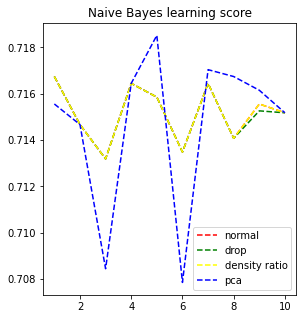

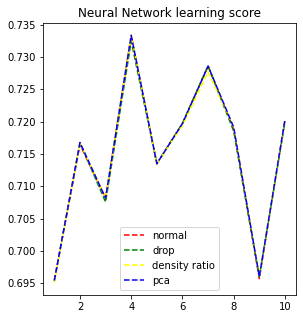

In [30]:
bin_array=[1,2,3,4,5,6,7,8,9,10]
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121) 
ax1.plot(bin_array,cross_nb,'--',color='red',label='normal') 
ax1.plot(bin_array,cross_nb_drop,'--',color='green',label='drop')
ax1.plot(bin_array,cross_nb_dens,'--',color='yellow',label='density ratio')
ax1.plot(bin_array,cross_nb_pca,'--',color='blue',label='pca')
ax1.set_title('Naive Bayes learning score') 
ax1.legend()

fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(121) 
ax2.plot(bin_array,cross_nc,'--',color='red',label='normal') 
ax2.plot(bin_array,cross_nc_drop,'--',color='green',label='drop')
ax2.plot(bin_array,cross_nc_dens,'--',color='yellow',label='density ratio')
ax2.plot(bin_array,cross_nc_pca,'--',color='blue',label='pca')
ax2.set_title('Neural Network learning score') 
ax2.legend()

In [29]:
###########################   PCA ##############################################################
feature_num=len(Xtr.columns)

g_score=[]
nn_score=[]
dim_array=[2,20,50,80,100,120]
for num in dim_array:
  Xtr_pca, Xts_pca = data_PCA(Xtr,Xts,feature_num)
  _,gb_acc,_=naive_bayes_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
  _,nn_acc,_=neural_classifier(Xtr_pca,ytr,Xts_pca,yts,'none')
  g_score.append(gb_acc)
  nn_score.append(nn_acc)

Train on 134995 samples, validate on 33749 samples
Epoch 1/2
134995/134995 [==============================] - 8s 56us/step - loss: 4699.5575 - accuracy: 0.7031 - val_loss: 1250.4444 - val_accuracy: 0.7151
Epoch 2/2
134995/134995 [==============================] - 7s 55us/step - loss: 1373.4798 - accuracy: 0.7102 - val_loss: 1179.4296 - val_accuracy: 0.7151
Epoch 1/1
3375/3375 [==============================] - 0s 28us/step
Epoch 1/1
3375/3375 [==============================] - 0s 28us/step
Epoch 1/1
3375/3375 [==============================] - 0s 27us/step
Epoch 1/1
3375/3375 [==============================] - 0s 28us/step
Epoch 1/1
3375/3375 [==============================] - 0s 27us/step
Epoch 1/1
3375/3375 [==============================] - 0s 30us/step
Epoch 1/1
3375/3375 [==============================] - 0s 27us/step
Epoch 1/1
3375/3375 [==============================] - 0s 27us/step
Epoch 1/1
3375/3375 [==============================] - 0s 27us/step
Epoch 1/1
3374/3374 [========

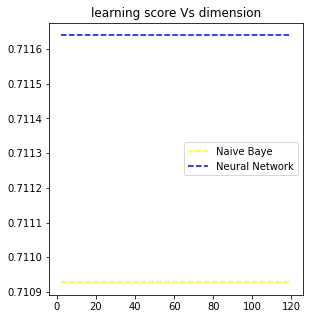

In [0]:
################## PCA dimension effect #######################
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121) 
ax1.plot(dim_array,g_score,'--',color='yellow',label='Naive Baye')
ax1.plot(dim_array,nn_score,'--',color='blue',label='Neural Network')
ax1.set_title('learning score Vs dimension') 
ax1.legend()